In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

import re # regular expression
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

In [2]:
data = pd.read_csv('../dataset/1.ramen-ratings.csv')

In [144]:
data

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan-miao Noodles,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN
...,...,...,...,...,...,...,...
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Style Instant Rice Noodles",Bowl,Vietnam,3.5,NaN
2576,4,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,NaN
2577,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,NaN
2578,2,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,NaN


In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


# Preprocessing: Remove Unnecessary Data
Tiền Xử Lý Dữ Liệu với bộ dữ liệu nhận được

In [146]:
data.isna().sum() # This

Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64

In [147]:
data['Top Ten'].unique()

array([nan, '2016 #10', '2016 #1', '2016 #8', '2016 #5', '2016 #9',
       '2016 #7', '2015 #10', '2015 #7', '2015 #4', '2015 #9', '2015 #6',
       '2015 #1', '2013 #10', '2015 #8', '2014 #7', '2014 #4', '2014 #9',
       '2014 #10', '2014 #8', '2014 #5', '2014 #6', '2014 #1', '2013 #1',
       '2013 #2', '2013 #4', '\n', '2013 #9', '2013 #3', '2012 #10',
       '2012 #7', '2012 #5', '2012 #3', '2012 #6', '2012 #9', '2012 #1',
       '2012 #2', '2013 #6', '2012 #4'], dtype=object)

In [148]:
data['Top Ten'] = data['Top Ten'].replace('\n', np.NaN) # replace /n with null value (NaN)
data['isTopTen'] = data['Top Ten'].apply(lambda x: 0 if str(x) == 'nan' else 1) # repalce NaN with 0, else 1
data = data.drop('Top Ten', axis=1) # Remove the original Top Ten as it no longer useful
data = data.drop('Review #', axis=1) # Remove Review # as it is not useful

In [149]:
data.isna().sum()

Brand       0
Variety     0
Style       2
Country     0
Stars       0
isTopTen    0
dtype: int64

In [150]:
data = data.dropna(axis=0).reset_index(drop=True) # Drop any row that have any value

In [151]:
data

,Brand,Variety,Style,Country,Stars,isTopTen
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,0
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan-miao Noodles,Pack,Taiwan,1,0
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,0
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,0
4,Ching's Secret,Singapore Curry,Pack,India,3.75,0
...,...,...,...,...,...,...
2573,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Style Instant Rice Noodles",Bowl,Vietnam,3.5,0
2574,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,0
2575,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,0
2576,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,0


Next: Turn Seperate Word into Features

In [152]:
# Check for Noise: Unrated data and Unusual data
data.query("Stars == 'Unrated'")

,Brand,Variety,Style,Country,Stars,isTopTen
32,Ottogi,Plain Instant Noodle No Soup Included,Pack,South Korea,Unrated,0
122,Samyang Foods,Sari Ramen,Pack,South Korea,Unrated,0
993,Mi E-Zee,Plain Noodles,Pack,Malaysia,Unrated,0


In [153]:
data = data.drop(data.query("Stars == 'Unrated'").index, axis=0).reset_index(drop=True)

In [154]:
# "missing values" refer to cells i

In [155]:
# n your dataframe that do not contain any data.
print(f'Total Missing values: {data.isna().sum().sum()}')

Total Missing values: 0


In [156]:
data

,Brand,Variety,Style,Country,Stars,isTopTen
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,0
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan-miao Noodles,Pack,Taiwan,1,0
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,0
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,0
4,Ching's Secret,Singapore Curry,Pack,India,3.75,0
...,...,...,...,...,...,...
2570,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Style Instant Rice Noodles",Bowl,Vietnam,3.5,0
2571,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,0
2572,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,0
2573,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,0


# Engineering Variety Features

1. Extracting the "Variety" Column:

In [157]:
ramen_names = data.loc[:, 'Variety'] # extract Variety col only
ramen_names # print extracted result

0                                                   T's Restaurant Tantanmen 
1                 Noodles Spicy Hot Sesame Spicy Hot Sesame Guan-miao Noodles
2                                               Cup Noodles Chicken Vegetable
3                                               GGE Ramen Snack Tomato Flavor
4                                                             Singapore Curry
                                        ...                                  
2570    Hu Tiu Nam Vang ["Phnom Penh" style] Asian Style Instant Rice Noodles
2571                                           Oriental Style Instant Noodles
2572                                                           Tom Yum Shrimp
2573                                                     Tom Yum Chili Flavor
2574                                                               Miso Ramen
Name: Variety, Length: 2575, dtype: object

2. Stemming and Cleaning Each Ramen Name:
+ Stemming: Reduces words to their root form to increase efficiency (e.g., "running" becomes "run").
+ Cleaning: Converts to lowercase, removes punctuation, replaces numbers with the word "number", splits into words, and removes extra whitespace.

In [158]:
# Steming each word to increase efficiency
# Stemming reduces words to their root form (e.g., "running" becomes "run")
ps = PorterStemmer()

def process_name(name):
  new_name = name.lower() # Make lowercase
  new_name = re.sub(r'[^a-z0-9\s]', '', new_name) # Remove punctuation
  new_name = re.sub(r'[0-9]+', 'number', new_name) # Change numerical word to "number"
  new_name = new_name.split(" ") # Make string into a list of words
  new_name = list(map(lambda x: ps.stem(x), new_name)) # stemmed each word
  new_name = list(map(lambda x: x.strip(), new_name)) # remove whitespace from each stemmed word
  
  for i in range(len(new_name)):
    if new_name[i] == 'flavour':
      new_name[i] = 'flavor'

  # remove empty string if any existed
  if '' in new_name:
    new_name.remove('')
  return new_name

In [159]:
ramen_names = ramen_names.apply(process_name)
ramen_names

0                                                         [ts, restaur, tantanmen]
1                   [noodl, spici, hot, sesam, spici, hot, sesam, guanmiao, noodl]
2                                                     [cup, noodl, chicken, veget]
3                                              [gge, ramen, snack, tomato, flavor]
4                                                                [singapor, curri]
                                           ...                                    
2570    [hu, tiu, nam, vang, phnom, penh, style, asian, style, instant rice noodl]
2571                                               [orient, style, instant, noodl]
2572                                                            [tom, yum, shrimp]
2573                                                     [tom, yum, chili, flavor]
2574                                                                 [miso, ramen]
Name: Variety, Length: 2575, dtype: object

3. Building the Vocabulary & Caclulating Maximum Length:

+ Vocabulary: A set of unique words from all the processed ramen names.

In [160]:
# Getting the number of unique words in our list of ramen names
vocabulary = set()

for name in ramen_names: # for each variety list
  for word in name: # for each ramen name in variety list
    if word not in vocabulary:
      vocabulary.add(word)

vocab_length = len(vocabulary)

# get the maximum length of a single ramen name
max_seq_length = max(ramen_names.apply(lambda x: len(x)))

In [161]:
print(f'  Vocabulary Length: {vocab_length} total unique word')
print(f'Max Sequence Length: {max_seq_length} is the maximum length of a ramen name')

  Vocabulary Length: 1368 total unique word
Max Sequence Length: 13 is the maximum length of a ramen name


## Tokenizer

In [162]:
# Assigning each unique word with a unique integer
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(ramen_names)

word_index = tokenizer.word_index
word_index

{'noodl': 1,
 'flavor': 2,
 'instant': 3,
 'ramen': 4,
 'chicken': 5,
 'spici': 6,
 'beef': 7,
 'cup': 8,
 'soup': 9,
 'with': 10,
 'sauc': 11,
 'rice': 12,
 'artifici': 13,
 'curri': 14,
 'tom': 15,
 'shrimp': 16,
 'mi': 17,
 'hot': 18,
 'seafood': 19,
 'bowl': 20,
 'pork': 21,
 'style': 22,
 'yum': 23,
 'goreng': 24,
 'udon': 25,
 'veget': 26,
 'vermicelli': 27,
 'dema': 28,
 'orient': 29,
 'sesam': 30,
 'penang': 31,
 'tonkotsu': 32,
 'mushroom': 33,
 'yakisoba': 34,
 'number': 35,
 'vegetarian': 36,
 'ramyun': 37,
 'rasa': 38,
 'sour': 39,
 'black': 40,
 'kimchi': 41,
 'soy': 42,
 'miso': 43,
 'chow': 44,
 'big': 45,
 'fri': 46,
 'shoyu': 47,
 'japanes': 48,
 'onion': 49,
 'mein': 50,
 'creami': 51,
 'king': 52,
 'a': 53,
 'tomato': 54,
 'laksa': 55,
 'super': 56,
 'thai': 57,
 'stew': 58,
 'dri': 59,
 'oil': 60,
 'korean': 61,
 'new': 62,
 'white': 63,
 'crab': 64,
 'sabor': 65,
 'tast': 66,
 'origin': 67,
 'yam': 68,
 'chili': 69,
 'bean': 70,
 'ayam': 71,
 'snack': 72,
 'pepper'

### Tokenized ramen_name

In [163]:
#? transform ramen names into a series of integers
sequences = tokenizer.texts_to_sequences(ramen_names)

**Transform Sequence for Tensorflow**: Use zero as a padding value to make all sequences the same length

+ TensorFlow have a hard time with variable length sequences.

+ So we add 1 or zero either to the beginner or the end of the sequences so all the sequences are in the same length


In [164]:
# Use zero as a padding value to make all sequences the same length
name_features = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
name_features 

array([[511, 402, 324, ...,   0,   0,   0],
       [  1,   6,  18, ...,   0,   0,   0],
       [  8,   1,   5, ...,   0,   0,   0],
       ...,
       [ 15,  23,  16, ...,   0,   0,   0],
       [ 15,  23,  69, ...,   0,   0,   0],
       [ 43,   4,   0, ...,   0,   0,   0]])

# Geting Remaining Features Ready

In [165]:
data = data.drop('Variety', axis=1) # Remove Variety as it is no longer useful

In [166]:
data

,Brand,Style,Country,Stars,isTopTen
0,New Touch,Cup,Japan,3.75,0
1,Just Way,Pack,Taiwan,1,0
2,Nissin,Cup,USA,2.25,0
3,Wei Lih,Pack,Taiwan,2.75,0
4,Ching's Secret,Pack,India,3.75,0
...,...,...,...,...,...
2570,Vifon,Bowl,Vietnam,3.5,0
2571,Wai Wai,Pack,Thailand,1,0
2572,Wai Wai,Pack,Thailand,2,0
2573,Wai Wai,Pack,Thailand,2,0


In [167]:
data['Style'].unique()

array(['Cup', 'Pack', 'Tray', 'Bowl', 'Box', 'Can', 'Bar'], dtype=object)

In [168]:
#? Example of One Hot Encoding for 1 Column
# pd.get_dummies(data['Style'], prefix='STYLE')

In [169]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1) # side by side instead of on top
        df = df.drop(column, axis=1)
    return df

### One Hot Encoding

In the data set, features like Brand, Style, Country is determinant by ramen_name. For example, is this ramen_name belong to a brand/style/country or not?

-> This turn into a True or False problem. 

-> So we could simplified these features using One Hot Encoding to each feature value into 1 or 0  

In [170]:
data = onehot_encode(
    data,
    ['Brand','Style', 'Country'],
    ['B', 'S', 'C']
)

In [171]:
data

,Stars,isTopTen,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,B_Acecook,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
0,3.75,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,2.25,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2.75,0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,3.75,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,3.5,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2571,1,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2572,2,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2573,2,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [172]:
# Extract labels and features
labels = data.loc[:, 'isTopTen'] # label is the main features we want to predict for each row
other_features = data.drop('isTopTen', axis=1) 

In [173]:
# Scale other features
scaler = StandardScaler()

other_features = pd.DataFrame(scaler.fit_transform(other_features), columns=other_features.columns) 

In [174]:
name_features_series = pd.Series(list(name_features), name='Name')

In [175]:
# merging tokenize ramen names with other features
features = pd.concat([name_features_series, other_features], axis=1)
features

,Name,Stars,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,B_Acecook,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
0,"[511, 402, 324, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.093660,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
1,"[1, 6, 18, 30, 6, 18, 30, 228, 1, 0, 0, 0, 0]",-2.614515,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,3.247628,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
2,"[8, 1, 5, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.383526,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,2.640480,-0.01971,-0.209232
3,"[267, 4, 72, 54, 2, 0, 0, 0, 0, 0, 0, 0, 0]",-0.891131,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,3.247628,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
4,"[129, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.093660,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,"[365, 699, 215, 510, 442, 443, 22, 100, 22, 0, 0, 0, 0]",-0.152537,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,4.779392
2571,"[29, 22, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-2.614515,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,3.532941,-0.165933,-0.378719,-0.01971,-0.209232
2572,"[15, 23, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.629724,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,3.532941,-0.165933,-0.378719,-0.01971,-0.209232
2573,"[15, 23, 69, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.629724,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,3.532941,-0.165933,-0.378719,-0.01971,-0.209232


In [176]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, random_state=34)

# Modeling and Training

In [177]:
name_features.shape

(2575, 13)

In [178]:
other_features.shape

(2575, 401)

In [179]:
class_weights = dict(
    enumerate(
        class_weight.compute_class_weight(
            class_weight='balanced',
            classes=y_train.unique(),
            y=y_train
        )
    )
)

class_weights

{0: 0.5084650112866818, 1: 30.033333333333335}

# ANN Model
**Set up each inputs seperately then concatenate them together later**

**Optional: Library to Plot Model**
+ conda install -c conda-forge python-graphviz
+ conda install -c anaconda pydot 

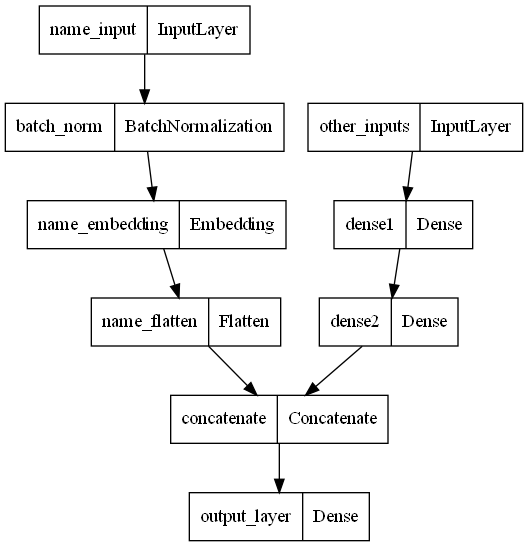

In [180]:

#! Our vocab length is 1371, do one-hot encoding would require a vector of length 1371 to encode a single word
#? Another way is to use a dense encoding. which turn word into n dimension vector (Word2Vec)
embeddings_dim = 64 #? in other word, this is the numbers to convey a word to a vector



#? Training on Name Features
name_inputs = tf.keras.Input(shape=(13,), name='name_input')

# Normalizing the input
batch_norm = tf.keras.layers.BatchNormalization(name='batch_norm')(name_inputs)

# Embedding the input
name_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length, # length of our vocabulary
    output_dim=embeddings_dim, # the vector dimension we wanted
    input_length=max_seq_length, # max sequence length: 13
    name='name_embedding'
)(batch_norm) 

name_outputs = tf.keras.layers.Flatten(name='name_flatten')(name_embedding)

#? Training on Other Features
other_inputs = tf.keras.Input(shape=(401, ), name='other_inputs')

hidden = tf.keras.layers.Dense(64, activation='relu', name='dense1')(other_inputs)
other_outputs = tf.keras.layers.Dense(64, activation='relu', name='dense2')(hidden)
    
#? Concatenate outputs and make predictions
concat = tf.keras.layers.concatenate([name_outputs, other_outputs], name='concatenate') 
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(concat)

#? Constructing and plotting model
model = tf.keras.Model(inputs=[name_inputs, other_inputs], outputs=outputs)


#? Plot the Model
tf.keras.utils.plot_model(model) # plot the model

In [181]:
X_train_1 = np.stack(X_train['Name'].to_numpy())
X_train_2 = X_train.drop('Name', axis=1)

X_test_1 = np.stack(X_test['Name'].to_numpy())
X_test_2 = X_test.drop('Name', axis=1)  

In [182]:
X_train_1

array([[1283,   19,   26, ...,    0,    0,    0],
       [  44,   50,  122, ...,    2,    0,    0],
       [ 153,  353,  354, ...,    0,    0,    0],
       ...,
       [ 322,   16,    0, ...,    0,    0,    0],
       [ 138,  168,   18, ...,    0,    0,    0],
       [ 330,    6,   14, ...,    0,    0,    0]])

In [183]:
X_train_2

,Stars,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,B_Acecook,B_Adabi,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
2039,-3.106910,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
732,0.832253,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,2.640480,-0.01971,-0.209232
429,1.324649,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,3.247628,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
282,-0.644933,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
2490,0.093660,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.339858,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232
324,-0.644933,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,3.532941,-0.165933,-0.378719,-0.01971,-0.209232
1897,-0.891131,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,4.779392
2538,-0.644933,-0.01971,-0.02788,-0.01971,-0.039444,-0.100995,-0.034153,-0.068425,-0.076547,-0.039444,...,-0.034153,-0.210241,-0.367915,-0.034153,-0.307917,-0.283050,-0.165933,-0.378719,-0.01971,-0.209232


In [184]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='prec'),
        tf.keras.metrics.Recall(name='rec')
    ]
)


batch_size = 64
epochs = 100

history = model.fit(
    [X_train_1, X_train_2],
    y_train,
    validation_split=0.2,
    class_weight=class_weights,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ],
    verbose=1
)

Epoch 1/100
23/23 [==============================] - 2s 20ms/step - loss: 0.6556 - accuracy: 0.6676 - auc: 0.5940 - prec: 0.0230 - rec: 0.5000 - val_loss: 0.5390 - val_accuracy: 0.8698 - val_auc: 0.6926 - val_prec: 0.0851 - val_rec: 0.5000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5488 - accuracy: 0.8897 - auc: 0.8790 - prec: 0.0898 - rec: 0.6818 - val_loss: 0.4830 - val_accuracy: 0.8310 - val_auc: 0.7636 - val_prec: 0.0656 - val_rec: 0.5000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4523 - accuracy: 0.8064 - auc: 0.9307 - prec: 0.0673 - rec: 0.9091 - val_loss: 0.4229 - val_accuracy: 0.8255 - val_auc: 0.7737 - val_prec: 0.0635 - val_rec: 0.5000 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3487 - accuracy: 0.8508 - auc: 0.9612 - prec: 0.0894 - rec: 0.9545 - val_loss: 0.3300 - val_accuracy: 0.8587 - val_auc: 0.8008 - val_prec: 0.1091 - val_rec: 0.7500 - lr

# Result

In [185]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "Epoch", 'y': "Loss"},
    title='Training and Validation Loss Over Time'
)

fig.show()

In [186]:
results = model.evaluate([X_test_1, X_test_2], y_test)

print(f'\n Accuracy: {results[1] :.5f}')
print(f'      AUC: {results[2] :.5f}')
print(f'Precision: {results[3] :.5f}')
print(f'   Recall: {results[4] :.5f}')

25/25 [==============================] - 0s 2ms/step - loss: 0.2199 - accuracy: 0.9082 - auc: 0.8056 - prec: 0.0676 - rec: 0.7143

 Accuracy: 0.90815
      AUC: 0.80558
Precision: 0.06757
   Recall: 0.71429


In [187]:
y_test.value_counts()

isTopTen
0    766
1      7
Name: count, dtype: int64

In [188]:
y_test.mean()

0.009055627425614488

In [189]:
print(f"Percent of ramens that are Top 10: {y_test.mean() * 100:.1f}%")

Percent of ramens that are Top 10: 0.9%


In [190]:
precision = results[3]  # Get the precision from the results
recall = results[4]  # Get the recall from the results

#? Calculate the F1 to see the balance between precision and recall
#? The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

0.12345678533582562